In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import stretched_echelle_widget as sew
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib notebook

# import stuff to plot

In [4]:
import pandas as pd 
highmass_rc = pd.read_csv('../datatables/highmass_rc_werr.csv')
highmass_rc_newvals = pd.read_csv('../datatables/highmass_rc_newvals.csv')
adopted_masses = pd.read_csv('../datatables/adopted_masses.csv')
pysyd_results = pd.read_csv('../datatables/pysyd_results.csv')

In [5]:
def read_star_sample(star_name,suppress_output=True,unpack=False):
#     delta_nu,nu_max,mass,lc,ps
    delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    mass = adopted_masses['corr_mass'][adopted_masses['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
#         print('Using new values')
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
        print('Adopted mass =',mass)
    
    lightcurve = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_PS.csv')
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,mass,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,mass,lightcurve,powerspec

In [6]:
def read_star_bsps(star_name,suppress_output=True,unpack=False):
    delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
    
    lightcurve = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/pysyd_bsps/'+star_name[4:]+'_BSPS.txt', 
                            delimiter='\s+', names=['freq','power'])
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,lightcurve,powerspec

# running the widget

In [357]:
kic_number = 9612933 #7988900 #6599955 #3120567 #9612933

In [358]:
delta_nu,nu_max,mass,lightcurve,powerspec = read_star_sample('KIC '+str(kic_number),suppress_output=False)
# delta_nu,nu_max,mass,time,flux,freq,power,amp = read_star('KIC 3758458',unpack=True,suppress_output=False)

freq = powerspec['freq']
power = powerspec['power']

smooth_percent = 0.02
freq_res = np.median(np.diff(freq))
smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

KIC 9612933
delta_nu = 4.432696858
nu_max = 52.46804315
Adopted mass = 3.79673774376972
returning dataframes


<IPython.core.display.Javascript object>


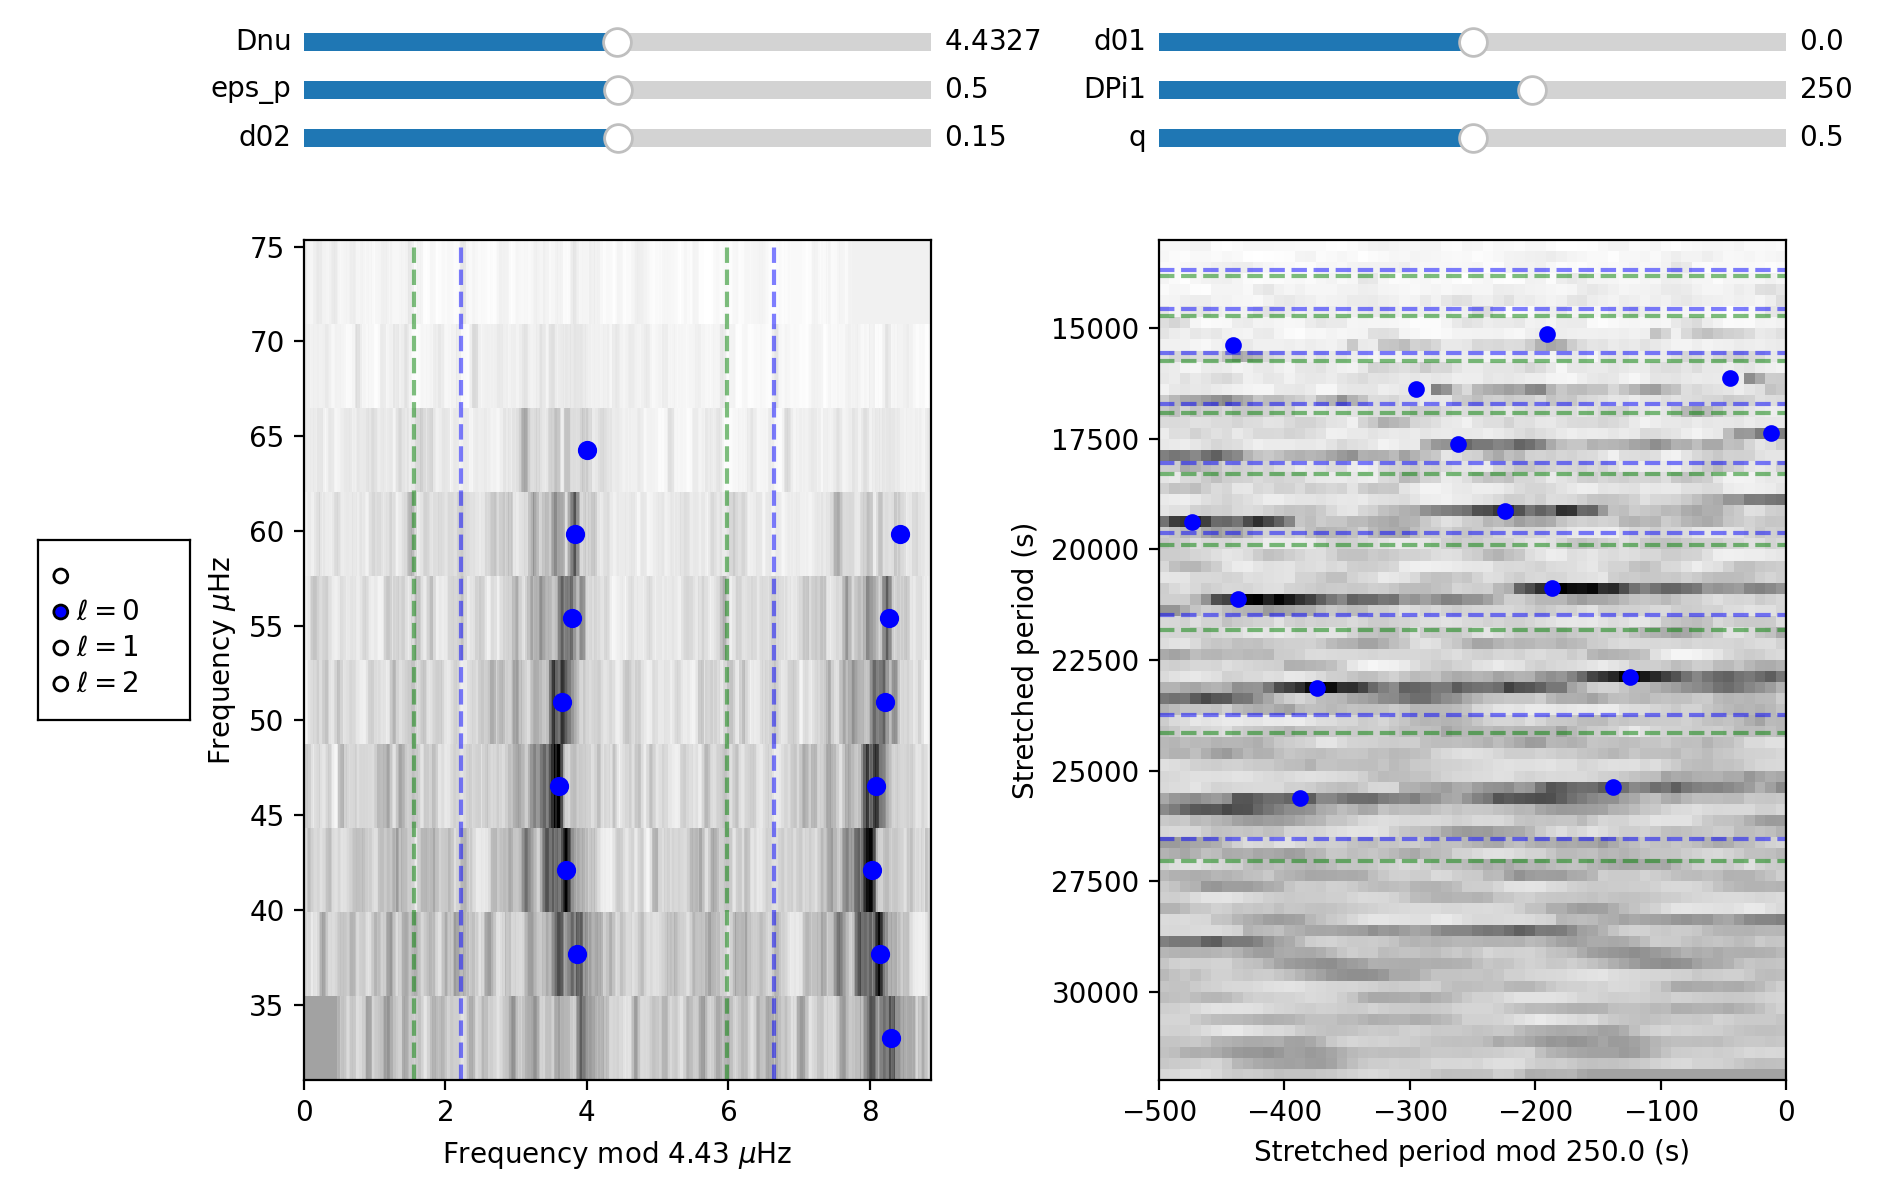

In [359]:
# resample spectrum to have 5000 pixels
# nu = np.linspace(nu_max-5*delta_nu, nu_max+5*delta_nu, 5000)
nu = np.linspace(0.5*nu_max, 1.5*nu_max, 5000)
ps = np.interp(nu, freq, smoothed_power)

# initiate a star object
star = sew.Star(nu, ps, nu_max, delta_nu,fmin=0.6*nu_max, fmax=1.5*nu_max)

# interactive echelles
star.plot_freq_echelle(snapping=True)#,plot_l1_line=True)
# plt.show()

In [25]:
star.f_labels

{0: [48.71265406406681,
  54.031739533928786,
  59.103122494164836,
  64.56561468012603,
  70.11936568542308,
  75.3863032585217,
  80.79664754771954,
  86.3503985530166],
 1: [45.675039077601525,
  45.675039077601525,
  46.770144909631924,
  50.81160690879176,
  51.32004890223445,
  51.71115812795959,
  55.84387894645529,
  56.37839488827966,
  56.80861503657732,
  57.369204926783354,
  61.110816519553914,
  61.72355430652331,
  62.24503327415683,
  62.88384500950791,
  66.41686501522506,
  67.21212044086617,
  67.74663638269054,
  68.63315062766753,
  71.63165469156031,
  72.59639078168235,
  73.18305462027006,
  74.21297558134627,
  77.69384769030006,
  78.44999219336867,
  79.38865433510902,
  83.33885751493298,
  84.02981714704741],
 2: [48.04776838033407,
  53.36685385019604,
  58.72505024263053,
  63.7703592544849,
  69.58484974359872,
  74.87786126507902,
  80.3012425284677]}

# Extra stuff with the output

In [10]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize,basinhopping

In [11]:
def lorentzian(x, amplitude, center, width):
    return (amplitude*width**2/((x-center)**2+width**2))

def peakbag(l,freq_list,freq,power,dnu):
    #want to fit a lorentzian to the region around the clicked peak
    for f in freq_list:
        # probably want to mask around the peak itself
        power_region = power[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        freq_region = freq[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        
        popt, pcov = curve_fit(lorentzian, freq_region, power_region,
                               p0=[max(power_region), f, 0.1])#,
#                               bounds=([0, 0, 0.05], np.inf))
        perr = np.sqrt(np.diag(pcov))
    
        def minus_log_likelihood(theta, freq, power):
            amp, cen, wid, bg = theta
            model = lorentzian(freq,amp,cen,wid) + bg
            return np.sum(np.log(model) + power/model)
        bnds = ((0, None), None, None, None)
#         res = minimize(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
#                        args=(freq_region,power_region), bounds=bnds)
        kwargs = dict({'args':(freq_region,power_region),'method':'BFGS','bounds':bnds})
        res = basinhopping(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
                       minimizer_kwargs=kwargs) # note that BFGS doesn't take bounds so this will have to change
        err = np.sqrt(np.diag(res.lowest_optimization_result.hess_inv))
    
        print('------- CURVE FIT VALUES --------')
        print('Amplitude:',np.round(popt[0],2),'+/-',np.round(perr[0],2))
        print('Center:',np.round(popt[1],2),'+/-',np.round(perr[1],2))
        print('Width:',np.round(popt[2],4),'+/-',np.round(perr[2],4))
        
        print('------- MINIMIZE VALUES ---------')
        print('Amplitude:',np.round(res.x[0],2),'+/-',np.round(err[0],2))
        print('Center:',np.round(res.x[1],2),'+/-',np.round(err[1],2))
        print('Width:',np.round(res.x[2],4),'+/-',np.round(err[2],4))
        print('BG:',np.round(res.x[3],1),'+/-',np.round(err[3],2))
        
#         print(res.lowest_optimization_result.hess_inv)
        
        fig = plt.figure(figsize=(4,2))
        plt.plot(freq_region,power_region,label='data')
        plt.plot(freq_region,lorentzian(freq_region,*popt),
                 linestyle='--',label='curve fit')
        plt.plot(freq_region,lorentzian(freq_region,*res.x[:-1]),
                 linestyle='--',label='minimize fit')
        plt.legend()
        plt.xlabel(r'Frequency ($\mu$Hz)')
        plt.ylabel('Power')
        plt.show()
        
def estimate_dpi(freq_list,numax,dnu):
    # a very back of the envelope estimate
#     freq_list = np.sort(freq_list)
    df = np.diff(freq_list)
    # only take the frequencies next to each other
    df = df[df < dnu*0.5]
    dpi = df/(numax**2) * 1e6
    print('All Dpis:',dpi)
    print('Average Dpi:',np.average(dpi))
    print('Average Dpi:',np.average(dpi))

In [12]:
estimate_dpi(star.f_labels[1],star.numax,star.Dnu)

All Dpis: []
Average Dpi: nan
Average Dpi: nan


In [13]:
# peakbag(1,star.f_labels[1],freq,power,star.Dnu)

# Mode Visibilities

$$A_{0}^{2}(n) = \delta \nu \int_{n-e_{20}}^{n+e_{03}}[p(n')-B]dn'$$
where p = power density, B = local background, $\delta \nu$ the frequency resolution   
where also $e_{12}$ = -0.22, $e_{20}$ = -0.065, $e_{03}$ = 0.17, $e_{31}$ = 0.27   
then   
$$\langle A_{\ell}^{2} \rangle = \sum_{n_{max}-2}^{n_{max}+2} A_{\ell}^{2}(n)/ \sum_{n_{max}-2}^{n_{max}+2} exp[\frac{-(\nu_{n,\ell}-\nu_{max})^2}{2\sigma^2}]$$
and the visibility is   
$$V_{\ell}^{2} = \langle A_{\ell}^{2} \rangle/\langle A_{0}^{2} \rangle$$

and you expect roughly $V_{1}^{2}$ = 1.54, $V_{2}^{2}$ = 0.58, $V_{3}^{2}$ = 0.043

also
$$n' = \nu/\Delta\nu - \epsilon(\Delta\nu)$$

In [360]:
delta_nu,nu_max,lightcurve,powerspec = read_star_bsps('KIC '+str(kic_number),suppress_output=False)

KIC 9612933
delta_nu = 4.432696858
nu_max = 52.46804315
returning dataframes


<IPython.core.display.Javascript object>


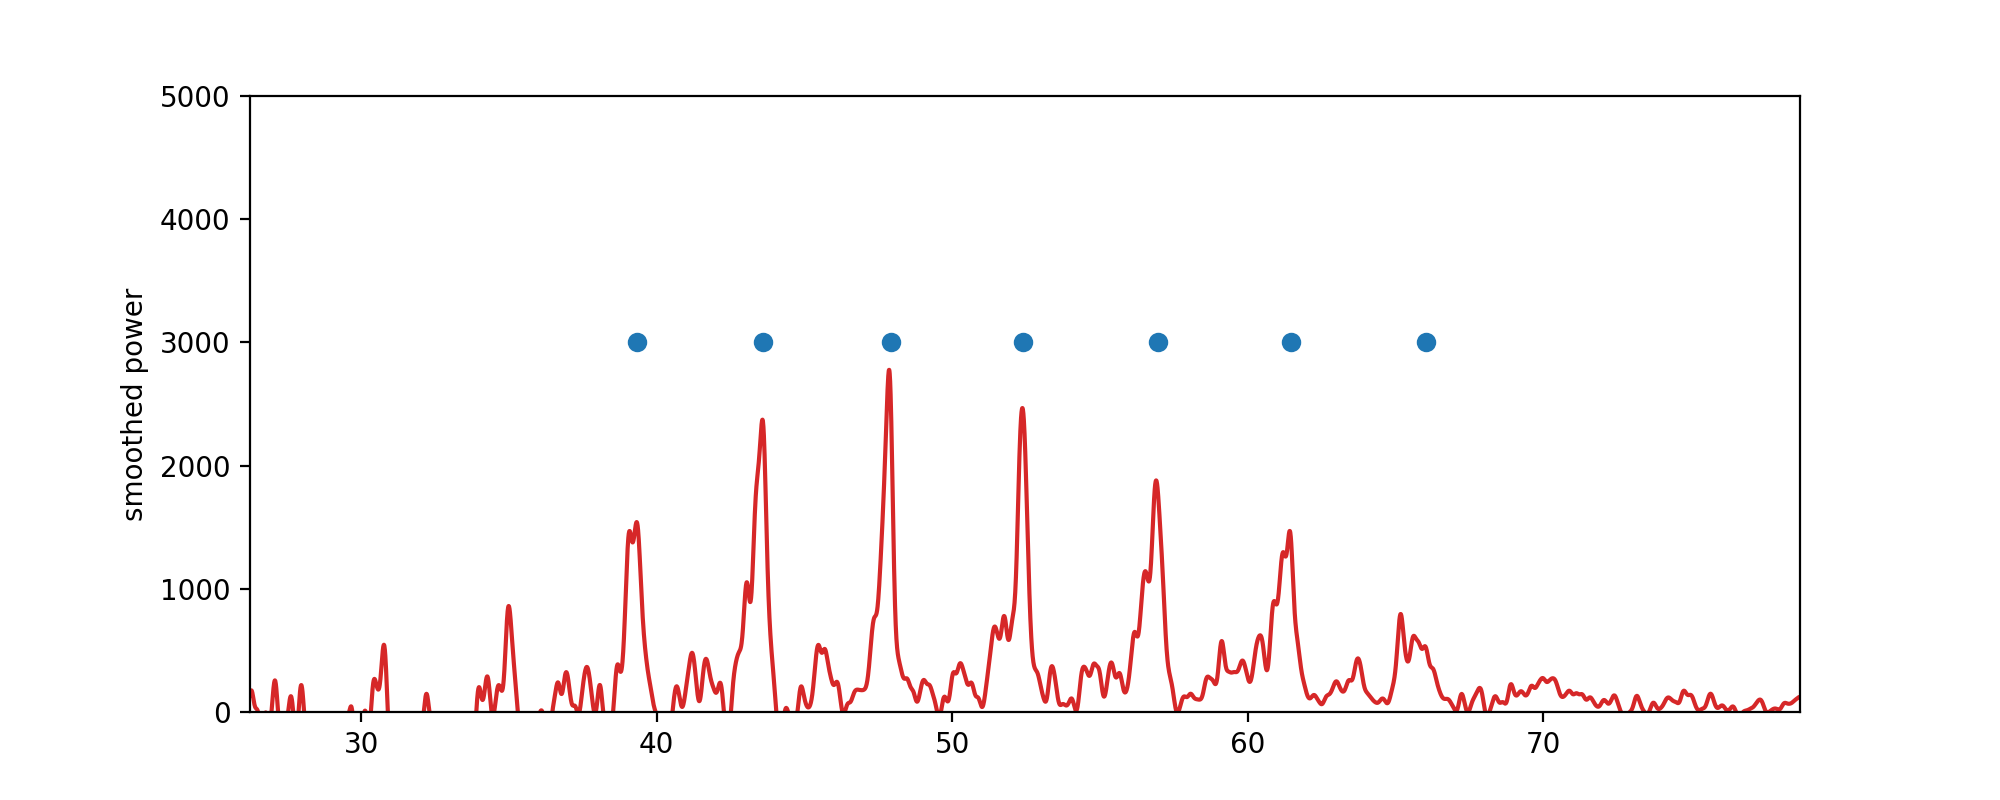

In [361]:
# radial = (7 + highmass_rc_newvals['epsilon'][highmass_rc_newvals['KIC']==3120567].values[0]*delta_nu)*delta_nu

plt.figure(figsize=(10,4))
# plt.plot(powerspec['freq'],powerspec['power'])
freq_res = np.median(np.diff(powerspec['freq']))
smooth_power = convolve(powerspec['power'],Gaussian1DKernel(0.02*delta_nu/freq_res))
plt.plot(powerspec['freq'],smooth_power,color='tab:red')

# peaks, _ = sp.signal.find_peaks(smooth_power,prominence=np.median(smooth_power)*250)#0.75)#prominence=10) 
# found_peaks = powerspec['freq'][peaks]
# plt.scatter(powerspec['freq'][peaks],smooth_power[peaks],marker='x',color='tab:green',s=30,zorder=3)

plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3000))

# plt.axvline(radial,color='k')

plt.xlim(nu_max*0.5,nu_max*1.5)
subset = powerspec['power'][(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(0,peak*1.1)
plt.ylim(top=5000)
plt.ylabel('smoothed power')
plt.show()

In [362]:
# widths are 0.16Δν, 0.53Δν and 0.16Δν wide for l = 0–2, respectively
# using l=2 modes 0.12Δν to the left and l=1 modes 0.52Δν to the right

In [363]:
## all from Stello 2016 (nature)
# l0_halfwidth = 0.08
# l2_halfwidth = 0.08
# l1_halfwidth = 0.265
# d02_spacing = 0.12
# d01_spacing = 0.52

# accounting for asymmetries Stello 2016 (PASA)
l0_halfwidth = 0.08
l2_halfwidth = 0.08
l1_halfwidth = 0.265
d02_spacing = 0.14
d01_spacing = 0.515

<IPython.core.display.Javascript object>


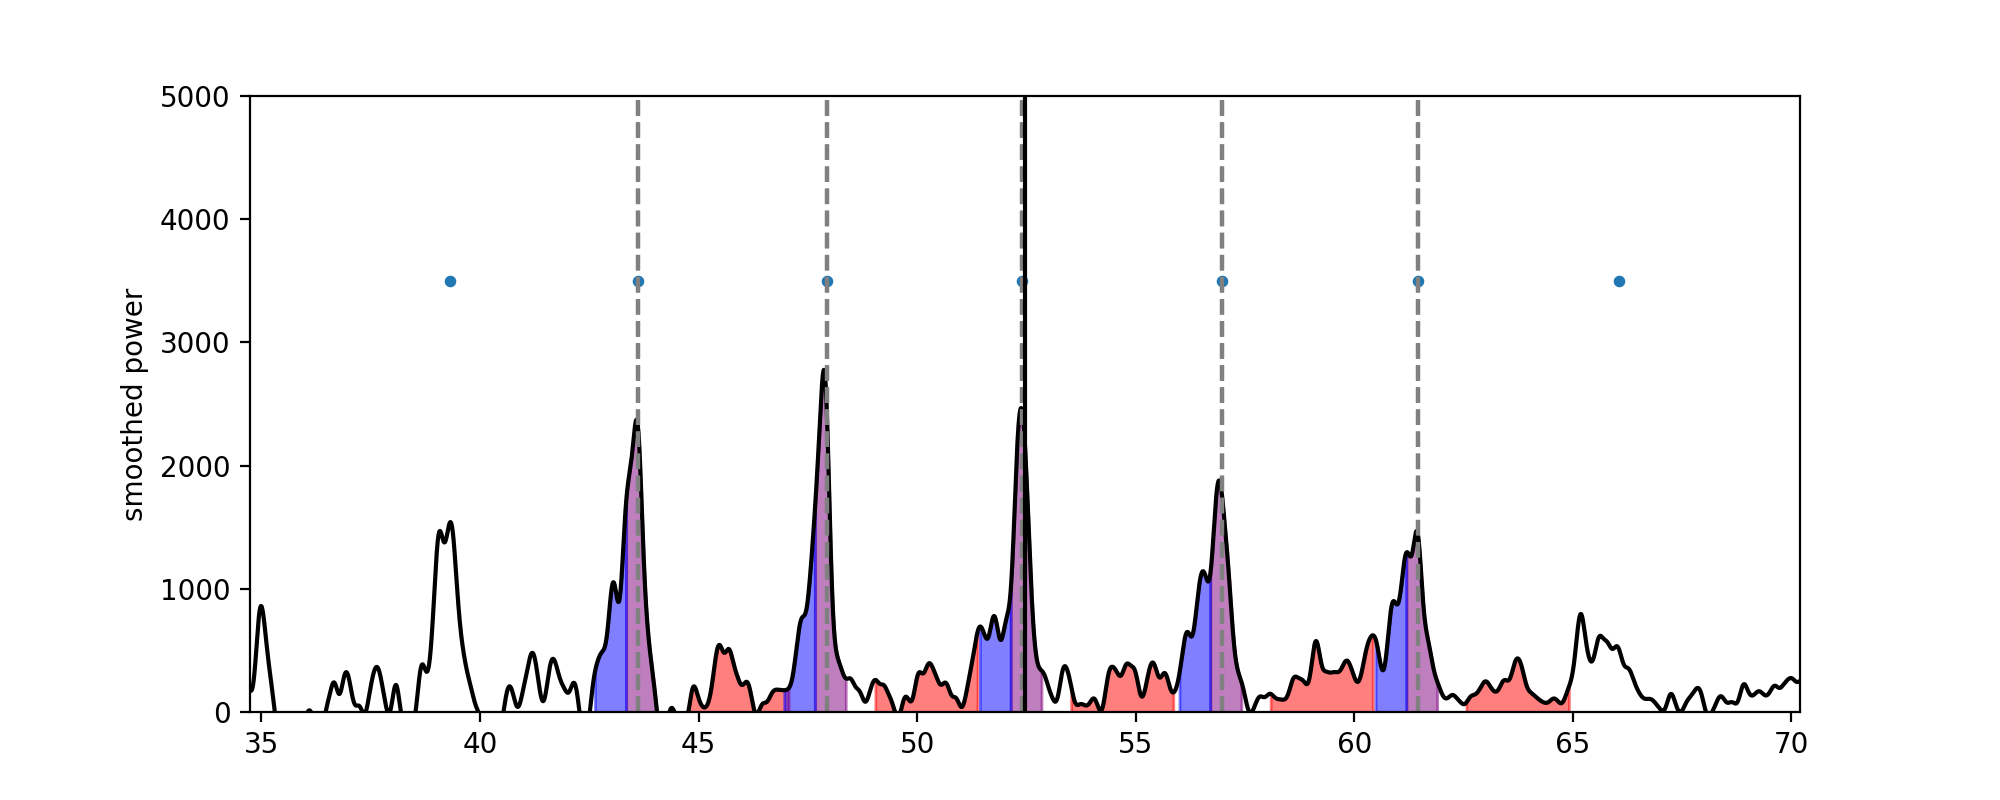

In [364]:
plt.figure(figsize=(10,4))
plt.plot(powerspec['freq'],smooth_power,color='k')

# plt.scatter(powerspec['freq'][peaks],smooth_power[peaks],marker='x',color='tab:green',s=30,zorder=3)

plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3500),s=10)
plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),3500),s=10)
plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),3500),s=10)

###################

def define_regions(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-(radial_mode+0.02*delta_nu))<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    

    plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][radial_region],smooth_power[radial_region], 0, color='purple',alpha=0.5)
    plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][quadru_region],smooth_power[quadru_region], 0, color='blue',alpha=0.5)
    plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][dipole_region],smooth_power[dipole_region], 0, color='red',alpha=0.5)
    
for i in [-2,-1,0,1,2]:
    define_regions(i)

###################

plt.axvline(nu_max,color='k')
plt.xlim(nu_max-4*delta_nu,nu_max+4*delta_nu)
subset = powerspec['power'][(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(0,peak*1.1)
plt.ylim(top=5000)
plt.ylabel('smoothed power')
plt.show()

$$A_{0}^{2}(n) = \delta \nu \int_{n-e_{20}}^{n+e_{03}}[p(n')-B]dn'$$
where p = power density, B = local background, $\delta \nu$ the frequency resolution   
where also $e_{12}$ = -0.22, $e_{20}$ = -0.065, $e_{03}$ = 0.17, $e_{31}$ = 0.27   
then   
$$\langle A_{\ell}^{2} \rangle = \sum_{n_{max}-2}^{n_{max}+2} A_{\ell}^{2}(n)/ \sum_{n_{max}-2}^{n_{max}+2} exp[\frac{-(\nu_{n,\ell}-\nu_{max})^2}{2\sigma^2}]$$
and
$$\delta\nu_{env} = 2\sqrt{2ln2}\sigma  \rightarrow  \sigma^2 = \frac{\delta\nu_{env}^2}{8ln2}$$
is the FWHM of the envelope

In [365]:
def find_mode_amps(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-radial_mode)<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu

    # using unsmoothed power here, that seems more right
    # I don't think I need to have the frequency resolution here??
    # need the power density!
    eff_obs_time = len(lightcurve) * 1800e-6
    l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
                                     y=powerspec['power'][radial_region]*eff_obs_time))*freq_res
    l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
                                     y=powerspec['power'][dipole_region]*eff_obs_time))*freq_res
    l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
                                     y=powerspec['power'][quadru_region]*eff_obs_time))*freq_res
    print(l0_amp,l1_amp,l2_amp)
    return l0_amp,l1_amp,l2_amp

l0_amp_arr = []
l1_amp_arr = []
l2_amp_arr = []
for i in [-2,-1,0,1,2]:
    l0,l1,l2 = find_mode_amps(i)
    l0_amp_arr.append(l0)
    l1_amp_arr.append(l1)
    l2_amp_arr.append(l2)

1054.0240847446512 435.20036134372015 506.66747566558246
1005.7525807668435 447.071657736507 402.69143550124625
977.0941811824352 462.37427753248187 414.38842755906745
804.8784868595812 674.6092383190507 517.4111764240228
701.0236859138639 409.129280854657 486.2904519986622


In [366]:
FWHM = pysyd_results['FWHM'][pysyd_results['KIC']==kic_number].values[0]
# FWHM = 1
# print(FWHM)
sigma_var = FWHM/(2*np.sqrt(2*np.log(2)))

def mean_calculation(index=0):
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    l0_denom = np.exp(-(radial_mode-nu_max)**2/(2*sigma_var**2))
    quadru_mode = radial_mode - d02_spacing*delta_nu
    l2_denom = np.exp(-(quadru_mode-nu_max)**2/(2*sigma_var**2))
    dipole_mode = radial_mode + d01_spacing*delta_nu
    l1_denom = np.exp(-(dipole_mode-nu_max)**2/(2*sigma_var**2))
    return l0_denom,l1_denom,l2_denom

l0_denom_arr = []
l1_denom_arr = []
l2_denom_arr = []
for i in [-2,-1,0,1,2]:
    l0_denom,l1_denom,l2_denom = mean_calculation(i)
    l0_denom_arr.append(l0_denom)
    l1_denom_arr.append(l1_denom)
    l2_denom_arr.append(l2_denom)
# l0_denom_arr

mean_l0_amp = np.sum(l0_amp_arr)/np.sum(l0_denom_arr)
mean_l1_amp = np.sum(l1_amp_arr)/np.sum(l1_denom_arr)
mean_l2_amp = np.sum(l2_amp_arr)/np.sum(l2_denom_arr)
print(mean_l0_amp,mean_l1_amp,mean_l2_amp)

1354.4972627598436 738.064136642173 695.3682071307311


In [367]:
l1_visibility = mean_l1_amp/mean_l0_amp
l2_visibility = mean_l2_amp/mean_l0_amp
print('Visibilites for KIC',kic_number)
print('dipole visiblity:',np.round(l1_visibility,2))
print('quadrupole visiblity:',np.round(l2_visibility,2))
### THESE ARE CONSISTENT WITH EXPECTED VALUES ###

Visibilites for KIC 9612933
dipole visiblity: 0.54
quadrupole visiblity: 0.51


# Regular period echelle (with freq list)

In [350]:
def period_echelle(freq_list,numax,dnu,dPi=0):
#     nu_max   = hist.nu_max.values[0]
#     Delta_nu = hist.delta_nu.values[0]
#     Delta_P_default = hist.delta_Pg.values[0] # seconds
#     if Delta_P == 0:
#         Delta_P = Delta_P_default
#     Delta_P = 300
#     print(Delta_P)
    
#     freq = freq[freq['Re(freq)'] < 5/3*numax]
#     dipole = freq[np.logical_and(freq.l == 1, freq.n_p > 2)]
#     period = 1/(dipole['Re(freq)']*1e-6)
    period_list = 1/(np.asarray(freq_list)*1e-6)
#     print(period)
    
#     plt.scatter(dipole['Re(freq)'] % Delta_P, dipole['Re(freq)'], 
#                 marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.figure(figsize=(6,10))
    plt.scatter(period_list % dPi, freq_list, 
                marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.plot(period_list % dPi, freq_list, linewidth=0.5)
    
#     colors = ('black', 'red', 'blue', 'purple')
#     for ell in np.unique(freq.l.values):
#         nus = freq[freq.l == ell]
#         plt.scatter(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], marker='.', 
#                 facecolor=colors[ell], edgecolor='k',linewidth=0.5,
#                     alpha=1, s=nus['E_p']*150, 
#                  label=str(ell))
#         plt.plot(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], '.', 
#                  mfc=colors[ell], mec='white', alpha=0.85,
#                  mew=1, markersize=nus['E_p'], 
#                  label=str(ell))
    
#     plt.legend(loc='lower right')
    
    plt.axvline(dPi, ls='--', c='darkgray', zorder=-99)
    plt.axhline(numax, ls='--', c='darkgray', zorder=-99)
    
#     plt.ylim([0, nu_max*5/3*1.2])
    plt.xlim([0, dPi])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'P $\rm{mod}\; \Delta P/s$ '+str(dPi))
    plt.title('Period Echelle Diagram', size=24)
    plt.show()

<IPython.core.display.Javascript object>


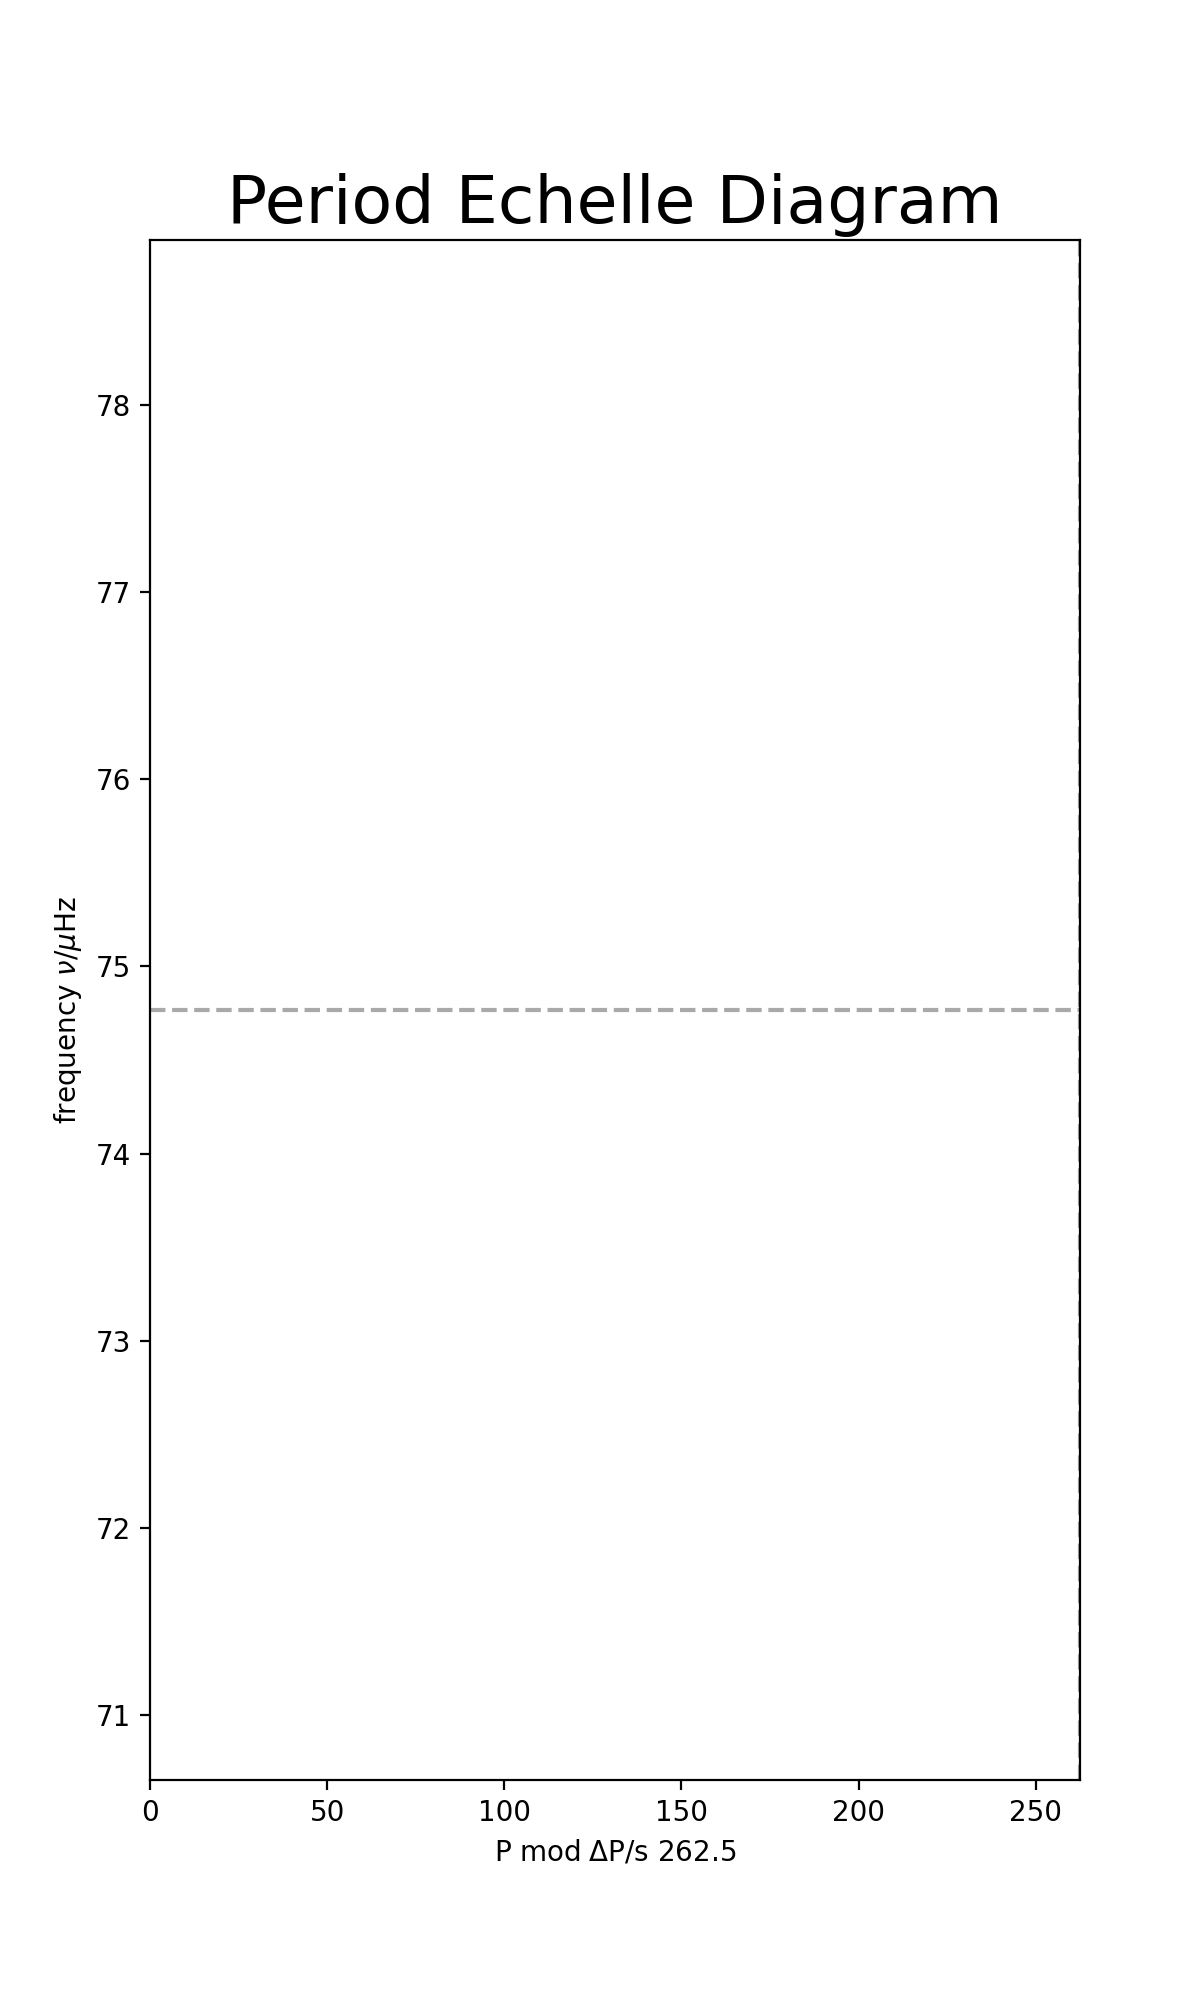

In [14]:
period_echelle(star.f_labels[1],star.numax,star.Dnu,dPi=262.5)